### Load the DeepMind AQuA Data Set 

In [1]:
import pandas as pd
import numpy as np
import json 

In [2]:
qb =  pd.read_json('AQuA-master/dev.json',lines=True)
qb.columns

Index(['correct', 'options', 'question', 'rationale'], dtype='object')

In [3]:
qb.head()

,correct,options,question,rationale
0,A,"[A)32400, B)6000, C)600, D)60000, E)10]",Three birds are flying at a fast rate of 900 k...,To calculate the equivalent of miles in a kilo...
1,D,"[A)100 m, B)150 m, C)200 m, D)250 m, E)300 m]",A ship is leaving a port. It takes 240 seconds...,Let the length of the ship be x metres and its...
2,C,"[A)6, B)18, C)24, D)36, E)48]",A rectangular piece of cloth 2 feet wide was c...,"The question says, length of shorter piece is ..."
3,B,"[A)(1,1), B)(0,3), C)(2,0), D)(3,6), E)(6,3)]","In the xy-coordinate plane, which of the follo...",For a point to satisfy the given equation for ...
4,C,"[A)7, B)9, C)13, D)27, E)45]",A travel company wants to charter a plane to t...,"Additional passengers (i.e., an integer, let's..."


### Remove Named Entities 

In [4]:
import nltk
import string
def untokenize(tokens):
    return("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip())


def extract_nonentities(tree):
    tokens = [leaf[0] for leaf in tree if type(leaf) != nltk.Tree]
    return(untokenize(tokens))

def ne_removal(text_list):
    token_list = [nltk.word_tokenize(text) for text in text_list]
    tagged = nltk.pos_tag_sents(token_list)
    chunked = nltk.ne_chunk_sents(tagged)
    non_entities = []
    for tree in chunked:
        non_entities.append(extract_nonentities(tree))
    return(non_entities)

In [5]:
# removal of named entities
qb['qn'] = ne_removal(qb['question'])


### Pre process text  - convert to lower case , remove numeric , special characters

In [6]:
import re
qb.qn = qb.qn.apply(lambda x: x.lower())
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\%', 'percent', x))
qb['qn'] = qb['qn'].apply(lambda x:re.sub("[^a-zA-Z]",' ',x))


In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Split the question into word list for vectorization

In [8]:
qb['qn']=qb['qn'].apply(lambda x: x.split())
qb.head()

,correct,options,question,rationale,qn
0,A,"[A)32400, B)6000, C)600, D)60000, E)10]",Three birds are flying at a fast rate of 900 k...,To calculate the equivalent of miles in a kilo...,"[three, birds, are, flying, at, a, fast, rate,..."
1,D,"[A)100 m, B)150 m, C)200 m, D)250 m, E)300 m]",A ship is leaving a port. It takes 240 seconds...,Let the length of the ship be x metres and its...,"[a, ship, is, leaving, a, port, it, takes, sec..."
2,C,"[A)6, B)18, C)24, D)36, E)48]",A rectangular piece of cloth 2 feet wide was c...,"The question says, length of shorter piece is ...","[a, rectangular, piece, of, cloth, feet, wide,..."
3,B,"[A)(1,1), B)(0,3), C)(2,0), D)(3,6), E)(6,3)]","In the xy-coordinate plane, which of the follo...",For a point to satisfy the given equation for ...,"[in, the, xy, coordinate, plane, which, of, th..."
4,C,"[A)7, B)9, C)13, D)27, E)45]",A travel company wants to charter a plane to t...,"Additional passengers (i.e., an integer, let's...","[a, travel, company, wants, to, charter, a, pl..."


### Tokenize all the word vectors

In [9]:
AllText = qb['qn'].values

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(AllText)
vocab_size = len(t.word_index) + 1
print(vocab_size)


Using TensorFlow backend.


1573


### Load the GloVe Word embeddings 

In [41]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('./glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors from GloVe.' % len(embeddings_index))

Loaded 400000 word vectors from GloVe.


### Create a word embeddings for the question vocabulary using the GloVe embeddings

In [42]:
# create a weight matrix for words in training docs
vocab = []
embedding_matrix = np.zeros((vocab_size, 300))
err_count = 0
for word, i in t.word_index.items():
    vocab.append(word)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else :
        print("Can't find Glove word vector for :{}".format(word))
        err_count +=1
vocab.append("-null")

Can't find Glove word vector for :yuvaraj
Can't find Glove word vector for :huhulians
Can't find Glove word vector for :prosthodontist
Can't find Glove word vector for :whatpercent
Can't find Glove word vector for :irder
Can't find Glove word vector for :thepercent
Can't find Glove word vector for :dbef
Can't find Glove word vector for :koolaid
Can't find Glove word vector for :playerwho


In [43]:
print(embedding_matrix.shape)

(1573, 300)


### Dimensionality Reduction using TSNE 

In [44]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
embedding_matrix_2d = tsne.fit_transform(embedding_matrix)

In [45]:
d = {"word":vocab,"x":embedding_matrix_2d[:,0],"y":embedding_matrix_2d[:,1]}
print(len(vocab))
pts=pd.DataFrame(d)
pts.head(10)

1573


,word,x,y
0,played,19.759895,-20.468645
1,pq,1.633576,9.820148
2,character,2.220507,10.114603
3,necessarily,4.625420,12.980789
4,become,-6.019231,4.154238
5,leaving,-1.552037,6.126178
6,keeps,0.951316,14.498993
7,last,-11.132826,-8.034027
8,enters,-11.316639,-1.656354
9,seven,13.063579,-0.149262


### Scatter plot of the word vectors 

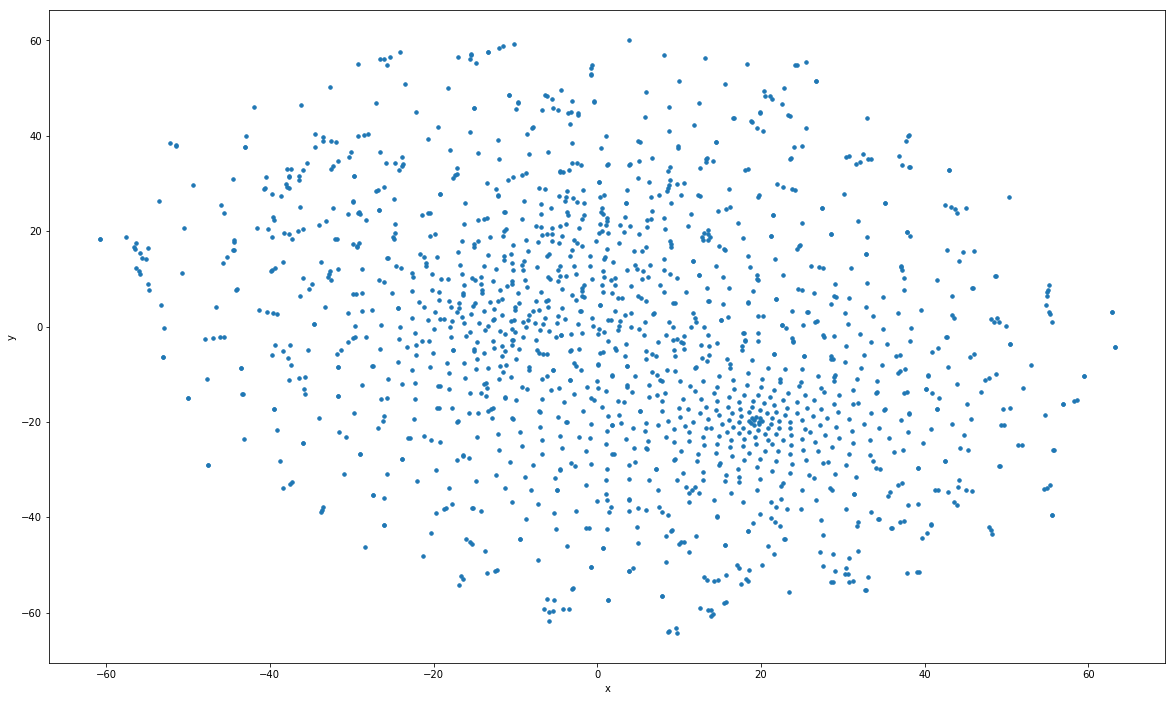

In [46]:
import seaborn as sns
%matplotlib inline
pts.plot.scatter("x", "y", s=12, figsize=(20, 12));

### Function to calculate the average vector for the sentence 

In [47]:
import numpy as np
from scipy import spatial


def avg_feature_vector(wordlist,  nfeatures):
    feature_vec = np.zeros((nfeatures, ), dtype='float32')
    nwords = 0

    for word in wordlist:

        if word in vocab : # word is glove-vocab
            nwords += 1
            if (embeddings_index.get(word)) is not None:
                feature_vec = np.add(feature_vec, embeddings_index.get(word))
    if (nwords > 0):
        feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

### For all the questions in Dataframe calculate the average feature vector

In [48]:
afv = []
for i in range(len(qb)) :
    fv = avg_feature_vector(qb['qn'][i], nfeatures=300)
    afv.append(fv)

### Cluster using the Average feature vector and cosine_distance as the 

In [50]:
from nltk.cluster import KMeansClusterer
import nltk

kclusterer = KMeansClusterer(10, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(afv, assign_clusters=True)
qb['clusters'] = assigned_clusters
qb.to_csv("dev300.csv")

In [51]:
qset = { 'question': qb.question, 'cluster': assigned_clusters }
frame = pd.DataFrame(qset, columns = ['question','cluster'])

In [52]:
grouped = frame['question'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
#print(grouped)
for key, item in grouped:
    print (grouped.get_group(key), "\n\n")

11     In how many arrangements can you arrange 3 gre...
22     Bill's shop sells candy bars by the full case....
34     At an elite baseball camp, 60% of players can ...
49     Scott bought three bags of candy with 75 piece...
52     A certain prosthodontist specializes in implan...
59     3 men and 3 women need to be seated in 2 rows ...
64     There are N numbers of gold biscuits in the ho...
93     A fair coin is tossed 6 times. If heads appear...
107    A shopkeeper gives a full bottle of soft drink...
123    A girl counted in the following way on the fin...
188    Lindsay can paint 25% of a certain room in 20 ...
211    In the reading room of a library, there are 10...
236    An oculist charges $30.00 for an eye examinati...
242    How many hand shakes will be there, if 8 peopl...
248    I have an amazing bath tub having both hot and...
Name: question, dtype: object 


8      ABC company pays an average of $120 per vehicl...
14     In a certain conservative mutual fund, 60 perc..